In [1]:
import os
import pandas as pd
import supereeg as se
import numpy as np
import copy
import nibabel as nib
from nilearn import plotting as ni_plt
from nilearn.image import resample_img
from nilearn import datasets, image
from scipy.spatial.distance import pdist, cdist
import scipy 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.colors as mplcol
import matplotlib as mpl
import seaborn as sns
from scipy.io import loadmat

/Users/lucyowen/.pyenv/versions/3.7.2/envs/my-data-project/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [14]:
def _fullfact(dims):
    '''
    Replicates MATLAB's _fullfact function (behaves the same way)
    '''
    vals = np.asmatrix(list(range(1, dims[0] + 1))).T
    if len(dims) == 1:
        return vals
    else:
        aftervals = np.asmatrix(_fullfact(dims[1:]))
        inds = np.asmatrix(np.zeros((np.prod(dims), len(dims))))
        row = 0
        for i in range(aftervals.shape[0]):
            inds[row:(row + len(vals)), 0] = vals
            inds[row:(row + len(vals)), 1:] = np.tile(aftervals[i, :], (len(vals), 1))
            row += len(vals)
        return inds

In [2]:
network_dir = '../../data/yeo_networks'

In [4]:
n_nets = 7

In [39]:
yeo_file = os.path.join(network_dir, 'Yeo2011_'+ str(n_nets) + 'Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz')
yeo = se.load(yeo_file)

In [40]:
yeo.affine

array([[  -1.,    0.,    0.,  127.],
       [   0.,    0.,    1., -145.],
       [   0.,   -1.,    0.,  147.],
       [   0.,    0.,    0.,    1.]])

In [59]:
downsampled = 10
downsampled_nii = se.Nifti(resample_img(yeo, target_affine=np.eye(3)*downsampled, interpolation='nearest'))

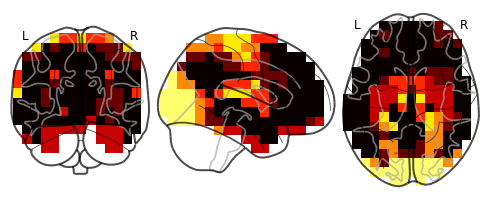

In [42]:
downsampled_nii.plot_glass_brain()

In [60]:
yeo_bo = se.Brain(downsampled_nii)

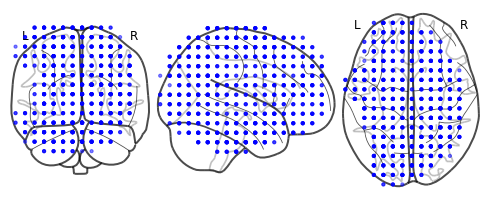

In [44]:
yeo_bo.plot_locs()

In [45]:
yeo_bo.affine

array([[  10.,    0.,    0., -128.],
       [   0.,   10.,    0., -145.],
       [   0.,    0.,   10., -108.],
       [   0.,    0.,    0.,    1.]])

In [46]:
downsampled_nii.affine[:, 0:3] = yeo.affine[:, 0:3]*downsampled

In [47]:
downsampled_nii.affine

array([[ -10.,    0.,    0., -128.],
       [   0.,    0.,   10., -145.],
       [   0.,  -10.,    0., -108.],
       [   0.,    0.,    0.,    1.]])

In [48]:
downsampled_nii.affine[0, 3] = downsampled_nii.affine[0, 3] * -1
downsampled_nii.affine[2, 3] = downsampled_nii.affine[2, 3] * -1

In [49]:
downsampled_nii.affine

array([[ -10.,    0.,    0.,  128.],
       [   0.,    0.,   10., -145.],
       [   0.,  -10.,    0.,  108.],
       [   0.,    0.,    0.,    1.]])

In [50]:
from nilearn.input_data import NiftiMasker
mask_file = None
nifti = downsampled_nii


if type(nifti) is se.nifti.Nifti:
    img = nifti
elif type(nifti) is nib.nifti1.Nifti1Image:
    img = nifti
elif type(nifti) is str:
    if os.path.exists(nifti):
        img = nib.load(nifti)
    else:
        print('Nifti format not supported')
else:
    print('Nifti format not supported')
    
mask = NiftiMasker(mask_strategy='background')
if mask_file is None:
    mask.fit(nifti)
else:
    mask.fit(mask_file)
hdr = img.header
S = img.get_sform()

Y = np.float64(mask.transform(nifti)).copy()

vmask = np.nonzero(np.array(np.reshape(mask.mask_img_.dataobj, (1, np.prod(mask.mask_img_.shape)), order='C')))[1]
vox_coords = _fullfact(img.shape[0:3])[vmask, :] - 1

R = np.array(np.dot(vox_coords, S[0:3, 0:3])) + S[:3, 3]

#return Y, R, {'header': hdr, 'unscaled_timing':True}, img.affine




In [51]:
old_brain = se.Brain(data=Y, locs=R, meta={'header': hdr, 'unscaled_timing':True}, affine=img.affine)

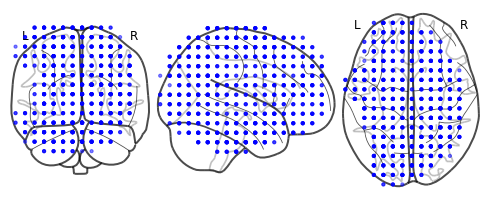

In [52]:
old_brain.plot_locs()

In [ ]:
old_brain = se.Brain(data=Y, locs=R, meta={'header': hdr, 'unscaled_timing':True}, affine=img.affine)

In [69]:
downsampled = 4
downsampled_nii = se.Nifti(resample_img(yeo, target_affine=np.eye(3)*downsampled, interpolation='nearest'))

In [70]:
yeo_bo = se.Brain(downsampled_nii)

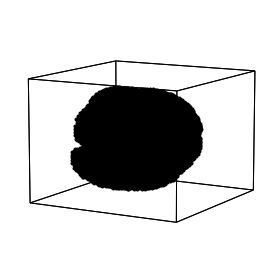

In [71]:
yeo_bo.plot_locs()

In [72]:
yeo_bo.save(os.path.join(network_dir, 'yeo_bo.bo'))

In [73]:

yeo_bo = se.load(os.path.join(network_dir, 'yeo_bo.bo'))

In [74]:
yeo_nii = se.load(os.path.join(network_dir, 'yeo_bo.bo'), return_type='nii', vox_size=10)




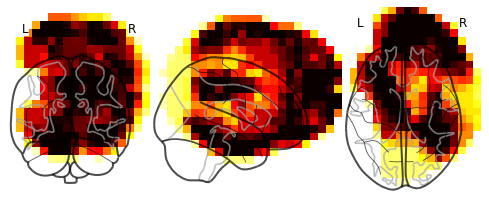

In [75]:
yeo_nii.plot_glass_brain()